In [233]:
from torchdiffeq import odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
import Plot3D as plot3d


#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

# Neural ODE's

In [234]:
class Simple_FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, activation_func=nn.Tanh()):
        super(Simple_FeedforwardNN, self).__init__()

        layers = []
        previous_depth = input_dim
        for _ in range(hidden_layers):
            layers.append(nn.Linear(previous_depth, depth))
            layers.append(activation_func)
            previous_depth = depth

        layers.append(nn.Linear(depth, output_dim))
        self.network = nn.Sequential(*layers)

        #Setting initial weights
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.2)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
            out = self.network(x)
            return out

In [235]:
class Auto_NODE(Simple_FeedforwardNN):
    def __init__(self, spatial_dim, hidden_layers, depth, activation_func=nn.Tanh()):
        super().__init__(spatial_dim, hidden_layers, depth, spatial_dim, activation_func)
        self.depth              = depth #Depth is number of neurons per hidden layer
        self.hiddenlayers       = hidden_layers #Number of internal hidden layers
        self.variables          = spatial_dim



    def forward(self, t, x):
        out = self.network(x)
        return out

In [236]:
class Piecewise_Auto_NODE(Simple_FeedforwardNN):
    def __init__(self, spatial_dim, hidden_layers, depth, time_range, num_breakpoints, activation_func=nn.Tanh()):
        super().__init__(spatial_dim, hidden_layers, depth, spatial_dim*(num_breakpoints+1), activation_func)
        self.depth              = depth #Depth is number of neurons per hidden layer
        self.hiddenlayers       = hidden_layers #Number of internal hidden layers
        self.variables          = spatial_dim
        self.num_breakpoint     = num_breakpoints
        self.time_range         = time_range
        self.num_A              = (num_breakpoints+1)
        self.breakpoints        = torch.linspace(time_range[0], time_range[1], num_breakpoints+2) 
        self.break_params       = nn.Parameter(self.breakpoints[1:-1])
        self.k = 1  #steepness parameter for sigmoid function
    
    
    def sigmoid(self, x):
       out = torch.sigmoid(self.k*x)
       return out
    


    def forward(self, t, x):
     
        out = self.network(x).reshape(self.num_A, self.variables)

        #First interval 
        i1 = self.sigmoid(self.break_params[0] - t).unsqueeze(0)
        output = i1

        #Internal Intervals
        for i in range(0, self.break_params.shape[0]-1):
            a = self.sigmoid(t - self.break_params[i]).unsqueeze(0)
            b = self.sigmoid(self.break_params[i+1] - t).unsqueeze(0)
            c = a*b
            output = torch.concatenate([output, c])
            
        #Final interval 
        i_final = self.sigmoid(t - self.break_params[-1]).unsqueeze(0)
        output = torch.cat([output, i_final])
        indicator = output.unsqueeze(0).T


        out2 = out*indicator
        final_out = torch.sum(out2, dim=0)
        return final_out

# Lorenz System

In [237]:
class Lorenz_nonauto:
    def __init__(self, rho, sigma = 10, beta = 8/3):
        #Setting system parameters
        self.sigma = sigma
        self.beta = beta
        self.rho = rho #should be a 1D function of time

    #Differential Equation
    def f(self, t, x):
        xdot = [self.sigma*(x[1]-x[0]),
                x[0]*(self.rho(t) - x[2]) - x[1],
                x[0]*x[1] - self.beta*x[2] ]

        return np.array(xdot)

## Batching 

In [246]:
#### Batching 
def batch_with_time(data_list, t_list, batch_length, batch_size): # data shape (traj, dim, time) #All traj same length 
    num_t_init = len(data_list) 

    batch_list = []
    batch_time_list = []
    for i in range(num_t_init):
        
        t_init_index = np.random.randint(0, num_t_init, 1)[0]
       
        data = data_list[t_init_index]
        time = t_list[t_init_index]
    
        #assume all t inits 
        num_traj = data.shape[0]
        data_length = data.shape[2]

        traj_indices = np.random.randint(0, num_traj, batch_size)
        ic_indices = np.random.randint(0, data_length - batch_length, batch_size)

        

        for i in range(0, batch_size):
            batch_list.append(data[traj_indices[i], :, ic_indices[i]:ic_indices[i]+batch_length].float())
            batch_time_list.append(time[ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))

    return batch_list, batch_time_list

In [247]:
#### Batching 
def batch(data, t, batch_length, batch_size): # data shape (traj, dim, time) #All traj same length 

    num_traj = data.shape[0]
    data_length = data.shape[2]

    traj_indices = np.random.randint(0, num_traj, batch_size)
    ic_indices = np.random.randint(0, data_length - batch_length, batch_size)

    batch_list = []
    batch_time_list = []

    for i in range(0, batch_size):
        batch_list.append(data[traj_indices[i], :, ic_indices[i]:ic_indices[i]+batch_length].float())
        batch_time_list.append(t[ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))

    return batch_list, batch_time_list

In [248]:
t_Start = 0; t_Final =80; dt = 0.05; t_Eval = np.arange(t_Start, t_Final, dt); y0 = [1, 1, 1]

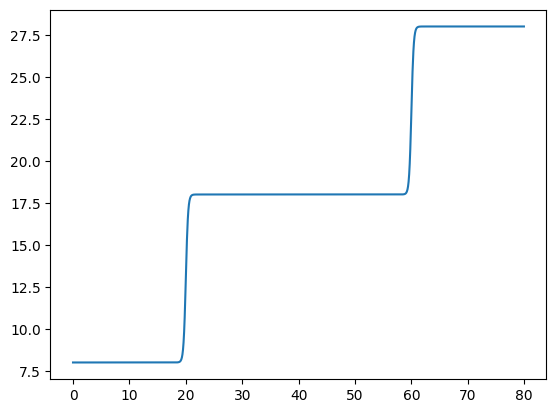

In [249]:
## Sigmoid r 
k = 5
s_k = lambda t: torch.sigmoid(torch.tensor(k*t)).detach().numpy()

transition_pts = [20.0, 60.0]

parameter_f = lambda t: 8 + 10*s_k(t-transition_pts[0]) + 10*s_k(t-transition_pts[1]) 



x= np.vectorize(parameter_f)(np.arange(0.0, t_Final, dt))
t = np.arange(0.0, t_Final, dt)
plt.plot(t, x)

In [250]:
lorenz = Lorenz_nonauto(rho = parameter_f)

In [251]:
t_init = [0, 30, 60]

In [265]:
data_list = []
time_list = []
for i in range(len(t_init)):
    t_span = (t_init[i], t_Final)
    t_eval = np.arange(t_init[i], t_Final, dt)
    sol = integ.solve_ivp(lorenz.f, t_span=t_span, y0=[1, 1, 1],
                            method = 'RK45', t_eval = t_eval)
    sol2 = integ.solve_ivp(lorenz.f, t_span=t_span, y0=[-1, -1, 1], method = 'RK45', t_eval = t_eval)
    
    training_data = torch.tensor(np.array([sol.y, sol2.y]))  
    data_list.append(training_data)
    time_list.append(torch.tensor(t_eval))

In [266]:
batch_list, batch_time_list = batch_with_time(data_list, time_list, batch_length=20, batch_size=5)

In [270]:
batch_list

[tensor([[ 3.7384,  4.1412,  5.0249,  6.4133,  8.3155, 10.5413, 12.4690, 13.0738,
          11.8076,  9.2699,  6.6361,  4.6710,  3.5258,  3.0636,  3.1365,  3.6583,
           4.6456,  6.1670,  8.2813, 10.8162],
         [ 4.0637,  5.4233,  7.2776,  9.7200, 12.5686, 14.9890, 15.3263, 12.4325,
           7.6321,  3.7218,  1.8972,  1.5883,  1.9781,  2.7168,  3.7384,  5.1512,
           7.1241,  9.8003, 13.0585, 15.9533],
         [20.7512, 19.0262, 18.0046, 18.0293, 19.6341, 23.3498, 28.8118, 33.7126,
          35.4204, 33.7337, 30.5106, 27.1250, 24.0664, 21.4151, 19.2025, 17.5054,
          16.5054, 16.5820, 18.3929, 22.6717]]),
 tensor([[12.5393, 12.1935, 10.4101,  8.0287,  5.9330,  4.5297,  3.8374,  3.7384,
           4.1412,  5.0249,  6.4133,  8.3155, 10.5413, 12.4690, 13.0738, 11.8076,
           9.2699,  6.6361,  4.6710,  3.5258],
         [13.4894,  9.8947,  5.9084,  3.3211,  2.3804,  2.4699,  3.0882,  4.0637,
           5.4233,  7.2776,  9.7200, 12.5686, 14.9890, 15.3263, 12.4325,

## Solving 

In [223]:
output = integ.solve_ivp(lorenz.f, t_span=(t_Start, t_Final), y0=[1, 1, 1],
                            method = 'RK45', t_eval = t_Eval)
data1 = output.y

output = integ.solve_ivp(lorenz.f, t_span=(t_Start, t_Final), y0=[-1, -1, 1],
                            method = 'RK45', t_eval = t_Eval)
data2 = output.y
training_data = np.array([data1, data2])

In [ ]:
batch_with_time()

In [182]:
print(data1.shape); print(int(transition_pts[0]/dt)); print(int(transition_pts[1]/dt))

(3, 1600)
400
1200


## Plotting

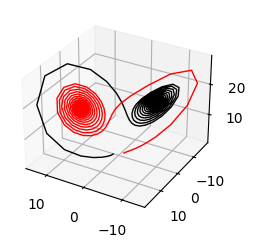

In [183]:
a = 0
b = 1200
#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=data1[0, a:b],     ys=data1[1, a:b], zs=data1[2, a:b], color = 'black', linewidth = 1 )
ax1.plot(xs=data2[0, a:b], ys=data2[1, a:b], zs=data2[2, a:b], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)

#Second Plot 
#ax2 = fig.add_subplot(1, 2, 2, projection='3d')


plt.show()

# Training Model 1

In [272]:
model = Piecewise_Auto_NODE(spatial_dim=3, hidden_layers=3, depth = 15, time_range = [0, t_Final], num_breakpoints=2)

In [273]:
model.break_params

Parameter containing:
tensor([26.6667, 53.3333], requires_grad=True)

In [274]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Putting data into tensor 
t_eval_tensor =  torch.tensor(np.arange(t_Start, t_Final, dt))
data_tensor = torch.tensor(training_data)

C:\Users\jackr\AppData\Local\Temp\ipykernel_3616\3305676170.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(training_data)


In [276]:
#Single training loop
optimizer.zero_grad()
pred_x = odeint(model, data_tensor[0, :, 0].float(), 
                t_eval_tensor.float(), method='rk4', options={'step_size': dt})

loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, data_list[0][0, :, 0].T.float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('')
print('Breakpoint: ', model.break_params)
print('')
print('Gradient of Breakpoint: ', model.break_params.grad)

C:\Users\jackr\AppData\Local\Temp\ipykernel_3616\2212856028.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4419.)
  train_loss = loss_fn(pred_x, data_list[0][0, :, 0].T.float())
c:\Users\jackr\OneDrive\Documents\GitHub\JackRoss-PhD-Notes\neural_odes\Lib\site-packages\torch\nn\modules\loss.py:132: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1600, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Total Loss:  tensor(3.3748, grad_fn=<MeanBackward0>)

Breakpoint:  Parameter containing:
tensor([26.6677, 53.3343], requires_grad=True)

Gradient of Breakpoint:  tensor([-0.0651, -0.0753])


In [277]:
batch_length = 100
batch_size = 5
num_epochs = 2000
for epoch in tqdm(range(num_epochs)):
    
    batch_list, batch_time_list = batch_with_time(data_list, time_list, batch_length=batch_length, batch_size=batch_size)
    for i in range(0, batch_size):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
        pred_x = odeint(model, batch_i[:, 0], batch_time_i, method='rk4', options={'step_size': dt})

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.T)
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()
     
    
    if epoch%20==0:
            #Calculate training loss
            temp_list = []
            for j in range(0, len(data_list)):
                for i in range(0, data_list[0].shape[0]):
                    pred_x = odeint(model, data_list[j][i, :, 0].float(), time_list[j], method='rk4', options={'step_size': dt})

                    temp_loss = loss_fn(pred_x, data_list[j][i,:,:].T)
                    temp_list.append(temp_loss.item())

            train_loss = np.array(temp_list).mean()
            loss_list.append(train_loss)
               
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

  0%|          | 1/2000 [00:22<12:32:48, 22.60s/it]

Epoch 0, Loss: 12.225999233781662


  5%|▌         | 101/2000 [08:27<5:01:35,  9.53s/it]

Epoch 100, Loss: 10.770250791653616


 10%|█         | 201/2000 [16:12<4:44:29,  9.49s/it]

Epoch 200, Loss: 10.86230625602912


 15%|█▌        | 301/2000 [24:07<4:40:26,  9.90s/it]

Epoch 300, Loss: 10.774548164635357


 20%|██        | 401/2000 [32:02<4:30:02, 10.13s/it]

Epoch 400, Loss: 10.532315199058576


 25%|██▌       | 501/2000 [39:50<4:00:09,  9.61s/it]

Epoch 500, Loss: 10.452791441949309


 30%|███       | 601/2000 [48:43<4:31:47, 11.66s/it]

Epoch 600, Loss: 10.160424897384308


 35%|███▌      | 701/2000 [57:37<3:54:29, 10.83s/it]

Epoch 700, Loss: 9.838637266991283


 40%|████      | 801/2000 [1:06:13<3:34:57, 10.76s/it]

Epoch 800, Loss: 9.909386869902143


 45%|████▌     | 901/2000 [1:14:59<3:23:40, 11.12s/it]

Epoch 900, Loss: 9.168133742836226


 50%|█████     | 1001/2000 [1:23:53<3:05:51, 11.16s/it]

Epoch 1000, Loss: 8.770825774180631


 55%|█████▌    | 1101/2000 [1:33:10<3:02:51, 12.20s/it]

Epoch 1100, Loss: 8.383212281544651


 60%|██████    | 1201/2000 [1:43:31<2:55:20, 13.17s/it]

Epoch 1200, Loss: 8.0702782346933


 65%|██████▌   | 1301/2000 [1:52:14<1:36:24,  8.28s/it]

Epoch 1300, Loss: 7.247095647063506


 70%|███████   | 1401/2000 [1:58:53<1:22:07,  8.23s/it]

Epoch 1400, Loss: 7.176664143312347


 75%|███████▌  | 1501/2000 [4:22:43<45:51,  5.51s/it]      

Epoch 1500, Loss: 7.91383194254277


 80%|████████  | 1601/2000 [4:27:01<35:25,  5.33s/it]

Epoch 1600, Loss: 7.0204066697674214


 85%|████████▌ | 1701/2000 [4:31:20<26:46,  5.37s/it]

Epoch 1700, Loss: 7.160343189175532


 90%|█████████ | 1801/2000 [4:35:16<16:14,  4.90s/it]

Epoch 1800, Loss: 7.143648262545


 95%|█████████▌| 1901/2000 [4:39:13<08:14,  4.99s/it]

Epoch 1900, Loss: 8.396989116434609


100%|██████████| 2000/2000 [4:43:00<00:00,  8.49s/it]


Text(0.5, 0, 'Epochs')

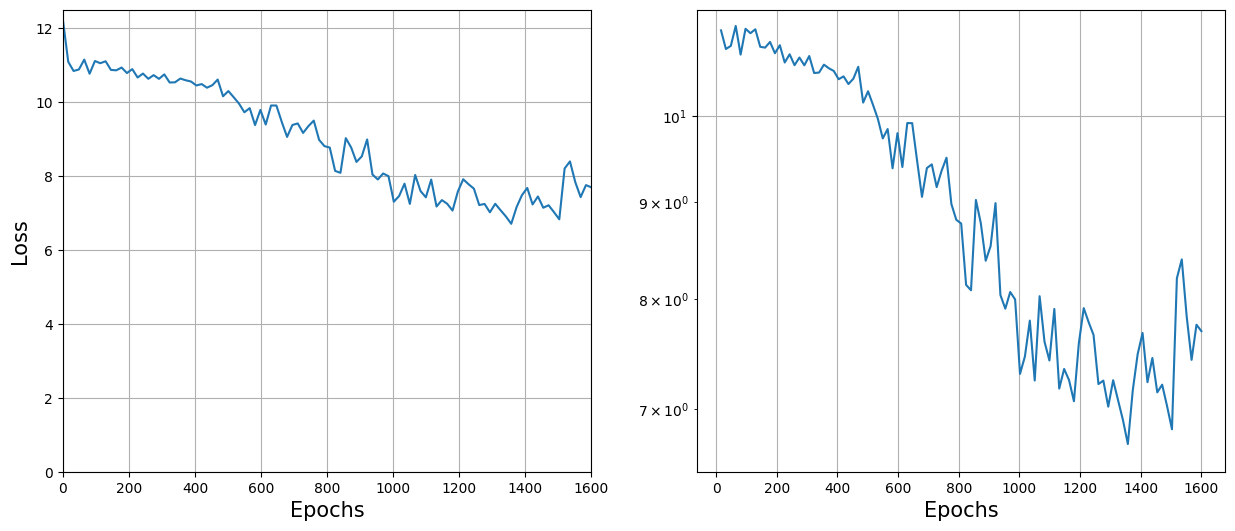

In [282]:
### Analysis  
epochs = 1600
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
ax2.set_ylim()
ax2.grid()
#plt.xscale('log')
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [17]:
model.break_params

Parameter containing:
tensor([ 8.0409, 13.4463], requires_grad=True)

In [20]:
node_data.shape

torch.Size([400, 3])

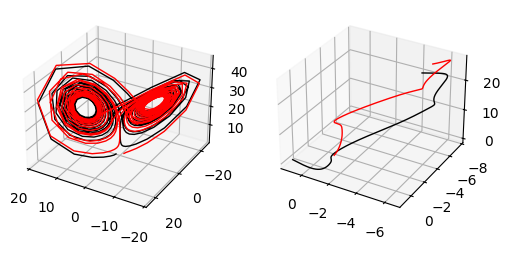

In [283]:
node_data = odeint(model, data_tensor[0, :, 0].float(), t_eval_tensor, method='rk4', options={'step_size': dt})
node_data1 = odeint(model, data_tensor[1, :, 0].float(), t_eval_tensor, method='rk4', options={'step_size': dt})


#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data[0, 0, :], ys=training_data[0, 1, :], zs=training_data[0, 2, :], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data[1, 0, :], ys=training_data[1, 1, :], zs=training_data[1, 2, :], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)

#Second Plot 
#ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), 
         color='black', linewidth=1)
ax2.plot(xs=node_data1[:, 0].detach().numpy(), ys=node_data1[:, 1].detach().numpy(), zs=node_data1[:, 2].detach().numpy(), 
         color='red', linewidth=1)

ax2.view_init(elev = 30, azim = 120)


plt.show()

# Training Model 2

In [ ]:
model2 = Piecewise_Auto_NODE(spatial_dim=3, hidden_layers=3, depth = 15, time_range = [0, 20], num_breakpoints=10)

In [ ]:
#Saving loss and setting optimiser 
loss_list2 = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Putting data into tensor 
t_eval_tensor =  torch.tensor(np.arange(t_Start, t_Final, dt))
data_tensor = torch.tensor(training_data)

In [ ]:
#Single training loop
optimizer.zero_grad()
pred_x = odeint(model, data_tensor[0, :, 0].float(), 
                t_eval_tensor.float(), method='rk4', options={'step_size': dt})

loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, data_tensor[0, :, :].T.float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('')
print('Breakpoint: ', model.break_params)
print('')
print('Gradient of Breakpoint: ', model.break_params.grad)

Total Loss:  tensor(1.0294, grad_fn=<MeanBackward0>)

Breakpoint:  Parameter containing:
tensor([ 6.6677, 13.3323], requires_grad=True)

Gradient of Breakpoint:  tensor([-0.0029,  0.0021])


In [ ]:
batch_length = 100
batch_size = 5
num_epochs = 5000
for epoch in tqdm(range(num_epochs)):
    
    batch_list, batch_time_list = batch(data_tensor, t_eval_tensor, batch_length=batch_length, batch_size=batch_size)
    for i in range(0, batch_size):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
        pred_x = odeint(model, batch_i[:, 0], batch_time_i, method='rk4', options={'step_size': dt})

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.T)
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()
     
    
    if epoch%20==0:
            #Calculate training loss
            temp_list = []
            for i in range(0, data_tensor.shape[0]):
                pred_x = odeint(model, data_tensor[i, :, 0].float(), t_eval_tensor, method='rk4', options={'step_size': dt})
                train_loss = loss_fn(pred_x, data_tensor[i,:,:].T)
                temp_list.append(train_loss.item())

            loss_list.append(np.array(temp_list).mean())
               
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

  0%|          | 1/1000 [00:03<55:39,  3.34s/it]

Epoch 0, Loss: 1.2266928651188118


  4%|▍         | 40/1000 [01:26<34:35,  2.16s/it]


In [ ]:
data_tensor.shape

torch.Size([2, 3, 400])